In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

data=pd.read_csv('Crypto_historical_data.csv')
target_crypto=['Bitcoin', 'Ethereum', 'Litecoin']
data=data[data['name'].isin(target_crypto)]
print(data['name'].unique())
print(data)


['Ethereum' 'Bitcoin' 'Litecoin']
                            Date        Open        High         Low  \
0      2017-11-09 00:00:00+00:00  308.644989  329.451996  307.056000   
1      2017-11-10 00:00:00+00:00  320.670990  324.717987  294.541992   
2      2017-11-11 00:00:00+00:00  298.585999  319.453003  298.191986   
3      2017-11-12 00:00:00+00:00  314.690002  319.153015  298.513000   
4      2017-11-13 00:00:00+00:00  307.024994  328.415009  307.024994   
...                          ...         ...         ...         ...   
67702  2025-12-05 00:00:00+00:00   83.566628   84.104477   79.832222   
67703  2025-12-06 00:00:00+00:00   80.490448   82.456062   80.000427   
67704  2025-12-07 00:00:00+00:00   81.702011   83.647766   80.030922   
67705  2025-12-08 00:00:00+00:00   81.424095   84.363342   81.150002   
67706  2025-12-10 00:00:00+00:00   86.096802   86.096802   84.345825   

            Close      Volume   ticker      name  
0      320.884003   893249984  ETH-USD  Ethereum  

In [2]:
date_col = 'Date'
non_numeric_cols = ['ticker', 'name']  
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']  
numeric_data = data[numeric_cols].copy() 
non_numeric_data = data[non_numeric_cols + [date_col]].copy()  
clear_numeric = numeric_data.copy()

for i in range(len(numeric_cols)):
    col = numeric_cols[i]  
    q1 = numeric_data[col].quantile(0.25)
    q3 = numeric_data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    mask = (numeric_data[col] >= lower_bound) & (numeric_data[col] <= upper_bound)
    clear_numeric = clear_numeric[mask]
remaining_indices = clear_numeric.index
clear_non_numeric = non_numeric_data.loc[remaining_indices].reset_index(drop=True)
clear_numeric = clear_numeric.reset_index(drop=True)
clear_combined = pd.concat([clear_non_numeric, clear_numeric], axis=1)
clear_combined = clear_combined.dropna()


df_clean=clear_combined
final_columns_order = [date_col] + numeric_cols + non_numeric_cols
df_clean = df_clean[final_columns_order]

print(df_clean['name'].unique())

['Ethereum' 'Bitcoin' 'Litecoin']


C:\Users\Пользователь\AppData\Local\Temp\ipykernel_7940\540267758.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clear_numeric = clear_numeric[mask]
C:\Users\Пользователь\AppData\Local\Temp\ipykernel_7940\540267758.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clear_numeric = clear_numeric[mask]
C:\Users\Пользователь\AppData\Local\Temp\ipykernel_7940\540267758.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clear_numeric = clear_numeric[mask]
C:\Users\Пользователь\AppData\Local\Temp\ipykernel_7940\540267758.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clear_numeric = clear_numeric[mask]



Матрица корреляции:
ticker   BTC-USD   ETH-USD   LTC-USD
ticker                              
BTC-USD  1.00000  0.458500  0.794880
ETH-USD  0.45850  1.000000  0.395623
LTC-USD  0.79488  0.395623  1.000000


<Axes: xlabel='ticker', ylabel='ticker'>

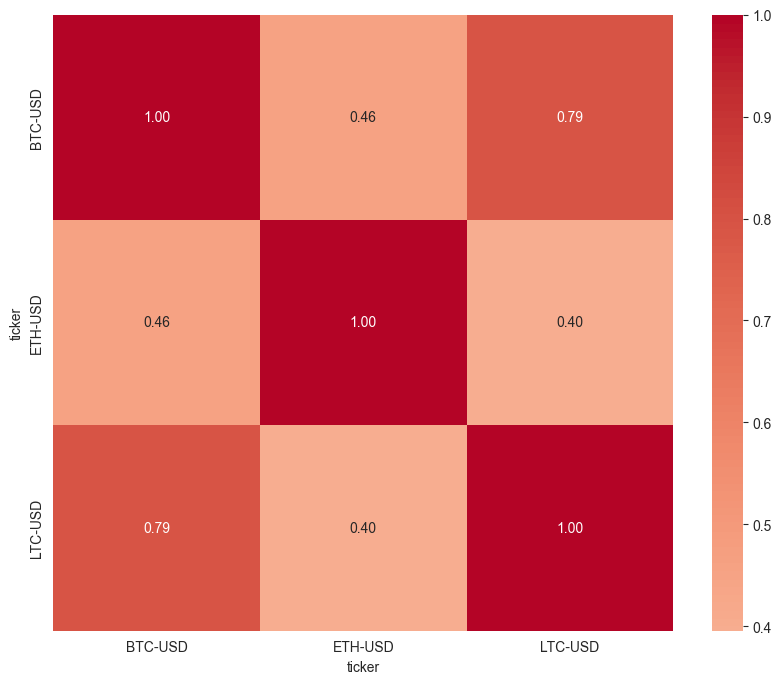

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

pivot_data = df_clean.pivot(index='Date', columns='ticker', values='Close')
correlation_matrix = pivot_data.corr()
print("\nМатрица корреляции:")
print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,  # Включаем подписи значений
            fmt='.2f',   # Формат чисел (2 знака после запятой)
            cmap='coolwarm',
            center=0
            )


In [4]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(
    df_clean, 
    test_size=0.2,  
    random_state=42,  
    shuffle=True  
)

LSTM Реализация

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def prepare_single_crypto_lstm(train_df, test_df, crypto_name='Bitcoin', 
                               sequence_length=60, feature_cols=['Close']):
    """
    Подготавливает данные для LSTM одной криптовалюты
    """
    # Фильтруем данные по криптовалюте
    train_crypto = train_df[train_df['name'] == crypto_name].copy()
    test_crypto = test_df[test_df['name'] == crypto_name].copy()
    
    print(f"\nКриптовалюта: {crypto_name}")
    print(f"  Тренировочные записи: {len(train_crypto)}")
    print(f"  Тестовые записи: {len(test_crypto)}")
    
    train_crypto = train_crypto.sort_values('Date')
    test_crypto = test_crypto.sort_values('Date')
    
    # Нормализация данных
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    train_features = scaler.fit_transform(train_crypto[feature_cols].values)
    test_features = scaler.transform(test_crypto[feature_cols].values)
    
    # Функция создания последовательностей
    def create_sequences(data, seq_length):
        sequences = []
        targets = []
        
        for i in range(seq_length, len(data)):
            sequences.append(data[i-seq_length:i])
            targets.append(data[i, 0])  # Предсказываем Close цену
            
        return np.array(sequences), np.array(targets)
    
    # Создаем последовательности
    X_train, y_train = create_sequences(train_features, sequence_length)
    X_test, y_test = create_sequences(test_features, sequence_length)
    
    # Преобразуем в тензоры PyTorch
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.FloatTensor(y_train).unsqueeze(1).to(device)  # [batch, 1]
    X_test = torch.FloatTensor(X_test).to(device)
    y_test = torch.FloatTensor(y_test).unsqueeze(1).to(device)
    
    print(f"  Размерности X_train: {X_train.shape}")
    print(f"  Размерности y_train: {y_train.shape}")
    print(f"  Размерности X_test: {X_test.shape}")
    print(f"  Размерности y_test: {y_test.shape}")
    
    return X_train, y_train, X_test, y_test, scaler

# Подготовка данных для Bitcoin
X_train, y_train, X_test, y_test, scaler = prepare_single_crypto_lstm(
    train_data, test_data, 
    crypto_name='Bitcoin',
    sequence_length=60,
    feature_cols=['Close']  # Можно добавить больше признаков
)



Криптовалюта: Bitcoin
  Тренировочные записи: 1730
  Тестовые записи: 435
  Размерности X_train: torch.Size([1670, 60, 1])
  Размерности y_train: torch.Size([1670, 1])
  Размерности X_test: torch.Size([375, 60, 1])
  Размерности y_test: torch.Size([375, 1])


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CryptoLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=3, 
                 output_size=1, dropout=0.3, bidirectional=True):
        super(CryptoLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        
        # 1. Первый LSTM слой
        self.lstm1 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=bidirectional
        )
        
        # 2. Второй LSTM слой (для извлечения дополнительных паттернов)
        self.lstm2 = nn.LSTM(
            input_size=hidden_size * self.num_directions,
            hidden_size=hidden_size // 2,
            num_layers=1,
            batch_first=True,
            bidirectional=False
        )
        
        # 3. BatchNorm слои
        self.batch_norm1 = nn.BatchNorm1d(hidden_size * self.num_directions)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size // 2)
        
        # 4. Dropout слои
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout * 0.7)
        
        # 5. Полносвязные слои
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_size // 4, hidden_size // 8),
            nn.ReLU(),
            nn.Dropout(dropout * 0.3),
            nn.Linear(hidden_size // 8, output_size)
        )
        
    def forward(self, x):
        # 1. Первый LSTM слой
        lstm1_out, _ = self.lstm1(x)  # [batch, seq_len, hidden*directions]
        
        # 2. Берем последний временной шаг из первого LSTM
        lstm1_last = lstm1_out[:, -1, :]  # [batch, hidden*directions]
        
        # 3. BatchNorm и Dropout
        lstm1_last = self.batch_norm1(lstm1_last)
        lstm1_last = self.dropout1(lstm1_last)
        
        # 4. Подготовка для второго LSTM
        # Повторяем lstm1_last для каждого временного шага
        context_expanded = lstm1_last.unsqueeze(1).repeat(1, x.size(1), 1)
        
        # 5. Второй LSTM слой
        lstm2_out, _ = self.lstm2(context_expanded)  # [batch, seq_len, hidden//2]
        lstm2_last = lstm2_out[:, -1, :]  # берем последний шаг
        
        # 6. BatchNorm и Dropout
        lstm2_last = self.batch_norm2(lstm2_last)
        lstm2_last = self.dropout2(lstm2_last)
        
        # 7. Полносвязные слои
        output = self.fc_layers(lstm2_last)
        
        return output

In [14]:
input_size = X_train.shape[2]  # Количество признаков
model = CryptoLSTM(
    input_size=input_size,
    hidden_size=64,
    num_layers=2,
    output_size=1,
    dropout=0.3
).to(device)

In [15]:
from torch.utils.data import DataLoader, TensorDataset
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:

import torch
import numpy as np

# Добавьте этот код в функцию обучения:
def train_model(model, train_loader, test_loader, epochs=100):
    train_losses = []
    val_losses = []
    
    print("\n" + "="*60)
    print("ОБУЧЕНИЕ")
    print("="*60)
    
    
    for epoch in range(epochs):     
        model.train()
        train_loss = 0
        batch_count = 0
        
        for batch_idx, (batch_X, batch_y) in enumerate(train_loader):
            # Проверка размеров батча
            if batch_idx == 0 and epoch == 0:
                print(f"\nРазмер первого батча:")
                print(f"  batch_X: {batch_X.shape}")
                print(f"  batch_y: {batch_y.shape}")
            
            optimizer.zero_grad()
            
            # Прямой проход
            outputs = model(batch_X)
            
            # Проверка выходов
            if batch_idx == 0 and epoch == 0:
                print(f"  outputs: {outputs.shape}")
                print(f"  outputs sample: {outputs[0].item():.6f}")
                print(f"  batch_y sample: {batch_y[0].item():.6f}")
            
            loss = criterion(outputs, batch_y)
            
            # Проверка loss
            if torch.isnan(loss):
                print(f"⚠️  NaN loss на батче {batch_idx}")
                break
            
            loss.backward()
            
            # Проверка градиентов
            if epoch == 0 and batch_idx == 0:
                total_grad_norm = 0
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        grad_norm = param.grad.norm().item()
                        total_grad_norm += grad_norm
                        if grad_norm == 0:
                            print(f"⚠️  Нулевой градиент: {name}")
                
                print(f"  Общая норма градиентов: {total_grad_norm:.6f}")
            
            optimizer.step()
            train_loss += loss.item()
            batch_count += 1
        
        # Средний loss
        if batch_count > 0:
            avg_train_loss = train_loss / batch_count
        else:
            avg_train_loss = 0
        
        train_losses.append(avg_train_loss)
        
        # Валидация
        model.eval()
        val_loss = 0
        val_batches = 0
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                val_batches += 1
        
        if val_batches > 0:
            avg_val_loss = val_loss / val_batches
        else:
            avg_val_loss = 0
        
        val_losses.append(avg_val_loss)
        
        
        # Выводим каждую эпоху для дебага
        print(f'Epoch [{epoch+1:3d}/{epochs}] | '
              f'Train Loss: {avg_train_loss:.6f} | '
              f'Val Loss: {avg_val_loss:.6f}')
        
    
    
    return train_losses, val_losses

In [17]:
test, test_sas=train_model(model, train_loader, test_loader)


ОБУЧЕНИЕ

Размер первого батча:
  batch_X: torch.Size([32, 60, 1])
  batch_y: torch.Size([32, 1])
  outputs: torch.Size([32, 1])
  outputs sample: -0.136316
  batch_y sample: 0.566270
⚠️  Нулевой градиент: lstm1.weight_hh_l1_reverse
  Общая норма градиентов: 3.708541
Epoch [  1/100] | Train Loss: 0.042657 | Val Loss: 0.033762
Epoch [  2/100] | Train Loss: 0.024521 | Val Loss: 0.009603
Epoch [  3/100] | Train Loss: 0.019218 | Val Loss: 0.008656
Epoch [  4/100] | Train Loss: 0.017141 | Val Loss: 0.007277
Epoch [  5/100] | Train Loss: 0.017262 | Val Loss: 0.007849
Epoch [  6/100] | Train Loss: 0.016022 | Val Loss: 0.006752
Epoch [  7/100] | Train Loss: 0.015971 | Val Loss: 0.011341
Epoch [  8/100] | Train Loss: 0.014242 | Val Loss: 0.006256
Epoch [  9/100] | Train Loss: 0.012948 | Val Loss: 0.006435
Epoch [ 10/100] | Train Loss: 0.012083 | Val Loss: 0.006933
Epoch [ 11/100] | Train Loss: 0.010029 | Val Loss: 0.004900
Epoch [ 12/100] | Train Loss: 0.011468 | Val Loss: 0.006123
Epoch [ 13/

In [18]:
model.eval()
with torch.no_grad():
    train_predict = model(X_train).cpu().numpy()
    test_predict = model(X_test).cpu().numpy()

# Обратное преобразование к исходному масштабу
train_predict_actual = scaler.inverse_transform(train_predict)
test_predict_actual = scaler.inverse_transform(test_predict)

y_train_actual = scaler.inverse_transform(y_train.cpu().numpy())
y_test_actual = scaler.inverse_transform(y_test.cpu().numpy())


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_predictions(y_true, y_pred, dataset_name):
    """Оценивает качество предсказаний"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n{dataset_name}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAPE': mape}


train_metrics = evaluate_predictions(y_train_actual, train_predict_actual, "Тренировочные данные")
test_metrics = evaluate_predictions(y_test_actual, test_predict_actual, "Тестовые данные")


Тренировочные данные:
  RMSE: 445.3781
  MAPE: 39.25%

Тестовые данные:
  RMSE: 771.4986
  MAPE: 27.15%


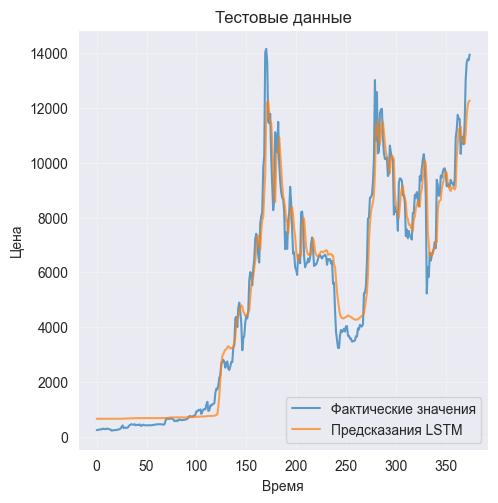

In [20]:
fig = plt.figure(figsize=(18, 12))
ax2 = plt.subplot(2, 3, 3)
ax2.plot(y_test_actual, label='Фактические значения', alpha=0.7)
ax2.plot(test_predict_actual, label='Предсказания LSTM', alpha=0.7)
ax2.set_title('Тестовые данные')
ax2.set_xlabel('Время')
ax2.set_ylabel('Цена')
ax2.legend()
ax2.grid(True, alpha=0.3)


In [21]:
X_train, y_train, X_test, y_test, scaler = prepare_single_crypto_lstm(
    train_data, test_data, 
    crypto_name='Ethereum',
    sequence_length=60,
    feature_cols=['Close']  # Можно добавить больше признаков
)

batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Криптовалюта: Ethereum
  Тренировочные записи: 2273
  Тестовые записи: 579
  Размерности X_train: torch.Size([2213, 60, 1])
  Размерности y_train: torch.Size([2213, 1])
  Размерности X_test: torch.Size([519, 60, 1])
  Размерности y_test: torch.Size([519, 1])


In [16]:
test, test_sas=train_model(model, train_loader, test_loader)


ОБУЧЕНИЕ

Размер первого батча:
  batch_X: torch.Size([32, 60, 1])
  batch_y: torch.Size([32, 1])
  outputs: torch.Size([32, 1])
  outputs sample: 0.475941
  batch_y sample: 0.500372
⚠️  Нулевой градиент: lstm1.weight_hh_l1_reverse
  Общая норма градиентов: 0.427568
Epoch [  1/100] | Train Loss: 0.004389 | Val Loss: 0.002644
Epoch [  2/100] | Train Loss: 0.004775 | Val Loss: 0.002788
Epoch [  3/100] | Train Loss: 0.005108 | Val Loss: 0.002702
Epoch [  4/100] | Train Loss: 0.004749 | Val Loss: 0.004192
Epoch [  5/100] | Train Loss: 0.004468 | Val Loss: 0.002411
Epoch [  6/100] | Train Loss: 0.004701 | Val Loss: 0.002696
Epoch [  7/100] | Train Loss: 0.004701 | Val Loss: 0.002690
Epoch [  8/100] | Train Loss: 0.004515 | Val Loss: 0.002576
Epoch [  9/100] | Train Loss: 0.004586 | Val Loss: 0.002874
Epoch [ 10/100] | Train Loss: 0.004453 | Val Loss: 0.002604
Epoch [ 11/100] | Train Loss: 0.004189 | Val Loss: 0.002588
Epoch [ 12/100] | Train Loss: 0.003951 | Val Loss: 0.002741
Epoch [ 13/1


Тренировочные данные:
  RMSE: 165.3116
  MAPE: 19.38%

Тестовые данные:
  RMSE: 226.2737
  MAPE: 20.99%


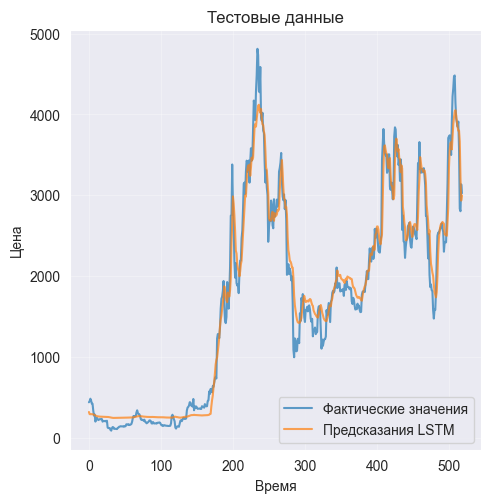

In [22]:
model.eval()
with torch.no_grad():
    train_predict = model(X_train).cpu().numpy()
    test_predict = model(X_test).cpu().numpy()

# Обратное преобразование к исходному масштабу
train_predict_actual = scaler.inverse_transform(train_predict)
test_predict_actual = scaler.inverse_transform(test_predict)

y_train_actual = scaler.inverse_transform(y_train.cpu().numpy())
y_test_actual = scaler.inverse_transform(y_test.cpu().numpy())

train_metrics = evaluate_predictions(y_train_actual, train_predict_actual, "Тренировочные данные")
test_metrics = evaluate_predictions(y_test_actual, test_predict_actual, "Тестовые данные")


fig = plt.figure(figsize=(18, 12))
ax2 = plt.subplot(2, 3, 3)
ax2.plot(y_test_actual, label='Фактические значения', alpha=0.7)
ax2.plot(test_predict_actual, label='Предсказания LSTM', alpha=0.7)
ax2.set_title('Тестовые данные')
ax2.set_xlabel('Время')
ax2.set_ylabel('Цена')
ax2.legend()
ax2.grid(True, alpha=0.3)


In [23]:
X_train, y_train, X_test, y_test, scaler = prepare_single_crypto_lstm(
    train_data, test_data, 
    crypto_name='Litecoin',
    sequence_length=60,
    feature_cols=['Close']  # Можно добавить больше признаков
)

batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Криптовалюта: Litecoin
  Тренировочные записи: 3292
  Тестовые записи: 810
  Размерности X_train: torch.Size([3232, 60, 1])
  Размерности y_train: torch.Size([3232, 1])
  Размерности X_test: torch.Size([750, 60, 1])
  Размерности y_test: torch.Size([750, 1])


In [19]:
test, test_sas=train_model(model, train_loader, test_loader)


ОБУЧЕНИЕ

Размер первого батча:
  batch_X: torch.Size([32, 60, 1])
  batch_y: torch.Size([32, 1])
  outputs: torch.Size([32, 1])
  outputs sample: 0.334210
  batch_y sample: 0.210275
⚠️  Нулевой градиент: lstm1.weight_hh_l1_reverse
  Общая норма градиентов: 0.336403
Epoch [  1/100] | Train Loss: 0.002889 | Val Loss: 0.001697
Epoch [  2/100] | Train Loss: 0.001948 | Val Loss: 0.001647
Epoch [  3/100] | Train Loss: 0.001772 | Val Loss: 0.001605
Epoch [  4/100] | Train Loss: 0.001707 | Val Loss: 0.001645
Epoch [  5/100] | Train Loss: 0.001689 | Val Loss: 0.001634
Epoch [  6/100] | Train Loss: 0.001607 | Val Loss: 0.001508
Epoch [  7/100] | Train Loss: 0.001710 | Val Loss: 0.001574
Epoch [  8/100] | Train Loss: 0.001598 | Val Loss: 0.001583
Epoch [  9/100] | Train Loss: 0.001478 | Val Loss: 0.001377
Epoch [ 10/100] | Train Loss: 0.001551 | Val Loss: 0.001507
Epoch [ 11/100] | Train Loss: 0.001644 | Val Loss: 0.001600
Epoch [ 12/100] | Train Loss: 0.001513 | Val Loss: 0.001570
Epoch [ 13/1


Тренировочные данные:
  RMSE: 18.5601
  MAPE: 99.05%

Тестовые данные:
  RMSE: 23.0254
  MAPE: 72.65%


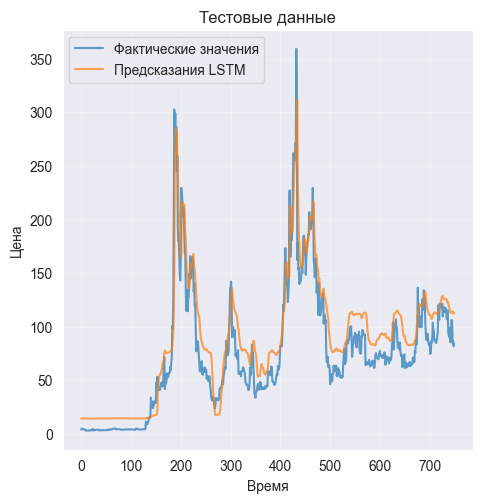

In [24]:
model.eval()
with torch.no_grad():
    train_predict = model(X_train).cpu().numpy()
    test_predict = model(X_test).cpu().numpy()

# Обратное преобразование к исходному масштабу
train_predict_actual = scaler.inverse_transform(train_predict)
test_predict_actual = scaler.inverse_transform(test_predict)

y_train_actual = scaler.inverse_transform(y_train.cpu().numpy())
y_test_actual = scaler.inverse_transform(y_test.cpu().numpy())

train_metrics = evaluate_predictions(y_train_actual, train_predict_actual, "Тренировочные данные")
test_metrics = evaluate_predictions(y_test_actual, test_predict_actual, "Тестовые данные")


fig = plt.figure(figsize=(18, 12))
ax2 = plt.subplot(2, 3, 3)
ax2.plot(y_test_actual, label='Фактические значения', alpha=0.7)
ax2.plot(test_predict_actual, label='Предсказания LSTM', alpha=0.7)
ax2.set_title('Тестовые данные')
ax2.set_xlabel('Время')
ax2.set_ylabel('Цена')
ax2.legend()
ax2.grid(True, alpha=0.3)



################################################################################
GRU для Bitcoin
################################################################################

[Bitcoin] всего записей: 2165
  train seq: 1684, test seq: 421

[Bitcoin] окон (последовательностей) всего: 2105
[Bitcoin] примерно строк во временном ряду: 2165 (окна + seq_len)

--------------------------------------------------------------------------------
Схема модели (параметры по слоям)
--------------------------------------------------------------------------------
Слой                 Вход            Выход           Формула параметров       Кол-во
--------------------------------------------------------------------------------
GRU layer 0          1               100             3H*(in+H)+6H              30900
GRU layer 1          100             100             3H*(in+H)+6H              60600
GRU layer 2          100             100             3H*(in+H)+6H              60600
FC Linear 1          10

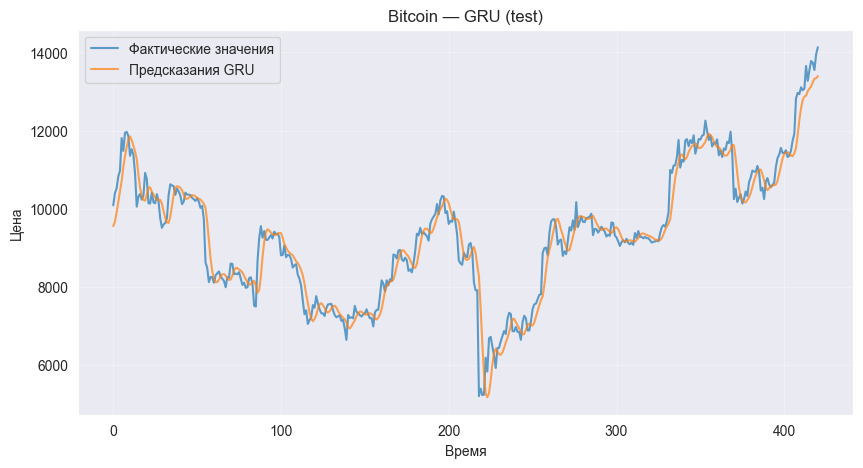


################################################################################
GRU для Ethereum
################################################################################

[Ethereum] всего записей: 2852
  train seq: 2233, test seq: 559

[Ethereum] окон (последовательностей) всего: 2792
[Ethereum] примерно строк во временном ряду: 2852 (окна + seq_len)

--------------------------------------------------------------------------------
Схема модели (параметры по слоям)
--------------------------------------------------------------------------------
Слой                 Вход            Выход           Формула параметров       Кол-во
--------------------------------------------------------------------------------
GRU layer 0          1               100             3H*(in+H)+6H              30900
GRU layer 1          100             100             3H*(in+H)+6H              60600
GRU layer 2          100             100             3H*(in+H)+6H              60600
FC Linear 1        

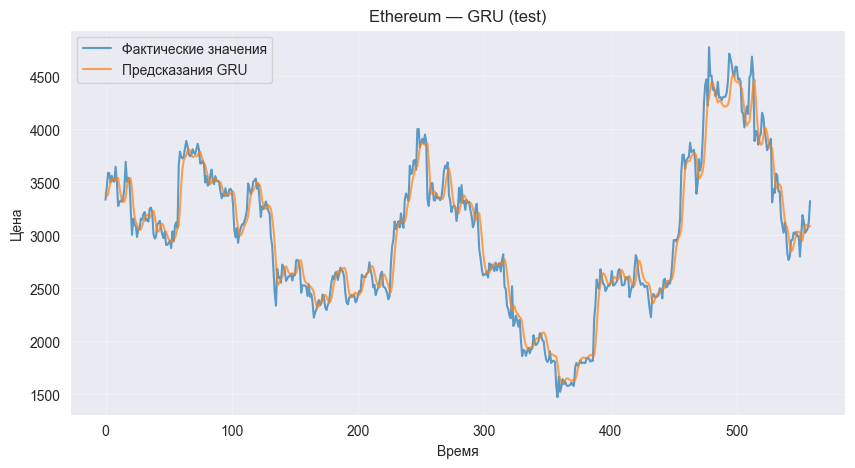


################################################################################
GRU для Litecoin
################################################################################

[Litecoin] всего записей: 4102
  train seq: 3233, test seq: 809

[Litecoin] окон (последовательностей) всего: 4042
[Litecoin] примерно строк во временном ряду: 4102 (окна + seq_len)

--------------------------------------------------------------------------------
Схема модели (параметры по слоям)
--------------------------------------------------------------------------------
Слой                 Вход            Выход           Формула параметров       Кол-во
--------------------------------------------------------------------------------
GRU layer 0          1               100             3H*(in+H)+6H              30900
GRU layer 1          100             100             3H*(in+H)+6H              60600
GRU layer 2          100             100             3H*(in+H)+6H              60600
FC Linear 1        

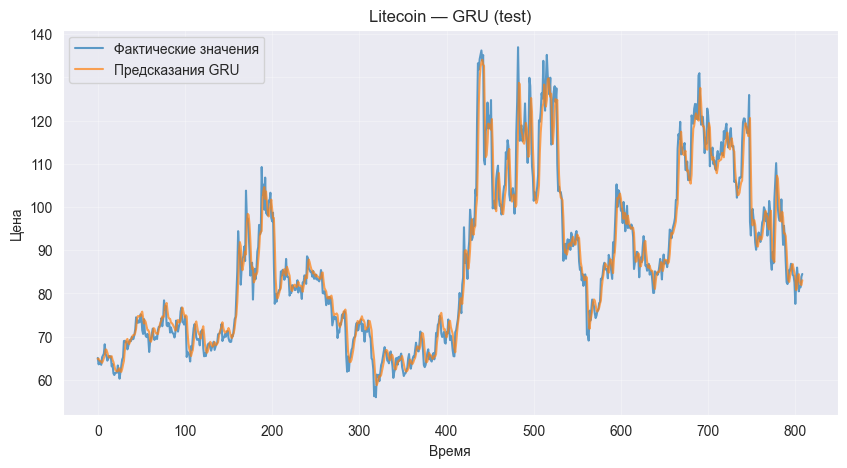

In [30]:
# ==========================================================================================
# ====================================== MASTER BLOCK ======================================
# ==========================================================================================
# Этот блок содержит ВСЁ: импорты, метрики, подготовка данных, модель, подсчёт параметров,
# колбэки (EarlyStopping/Checkpoint), train_model, run_gru_for_crypto, запуск 3 криптовалют.
# Запускай ОДНУ ячейку — и дальше всё будет определено, без NameError.
# ==========================================================================================


# ============================== 0) ИМПОРТЫ (общее) ========================================

# Импортируем os для работы с путями/папками (чекпоинты)
import os

# Импортируем copy для безопасного копирования best весов
import copy

# Импортируем NumPy для численных операций
import numpy as np

# Импортируем matplotlib для графиков
import matplotlib.pyplot as plt

# Импортируем PyTorch
import torch

# Импортируем модуль nn для слоёв и лоссов
import torch.nn as nn

# Импортируем optim для оптимизаторов
import torch.optim as optim

# Импортируем Dataset/DataLoader для батчей
from torch.utils.data import TensorDataset, DataLoader

# Импортируем scaler для нормализации
from sklearn.preprocessing import MinMaxScaler

# Импортируем метрики sklearn (у тебя в evaluate_predictions используется mean_squared_error)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# ============================== 1) УСТРОЙСТВО (CPU/GPU) ===================================

# Выбираем устройство для вычислений:
# если доступна видеокарта CUDA — используем её, иначе работаем на CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# ============================== 2) МЕТРИКИ =================================================

# Определяем функцию, которая считает метрики качества прогноза и печатает их
def evaluate_predictions(y_true, y_pred, dataset_name):

    # ===== Формулы метрик (простыми словами) =====
    # MSE = mean( (y_true - y_pred)^2 )
    # RMSE = sqrt(MSE)
    # MAPE = mean( abs( (y_true - y_pred) / (y_true + eps) ) )
    # Важно: MAPE тут возвращаем в ДОЛЯХ (0.05), а не в процентах (5%)

    # Считаем MSE (среднеквадратичную ошибку): среднее значение (y_true - y_pred)^2
    mse = mean_squared_error(y_true, y_pred)

    # Получаем RMSE (корень из MSE), чтобы ошибка была в тех же единицах, что и цена
    rmse = np.sqrt(mse)

    # Задаём маленькое число eps для защиты от деления на 0 в формуле MAPE
    eps = 1e-8  # защита от деления на 0

    # Считаем MAPE в виде доли (например 0.03), а не в процентах
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + eps)))

    # Печатаем название блока метрик
    print(f"\n{dataset_name}:")

    # Печатаем RMSE, форматируя до 4 знаков
    print(f"  RMSE: {rmse:.4f}")

    # Печатаем MAPE, форматируя до 4 знаков
    print(f"  MAPE: {mape:.4f}")

    # Возвращаем метрики словарём
    return {"MSE": mse, "RMSE": rmse, "MAPE": mape}


# ============================== 3) ПОДГОТОВКА ДАННЫХ =======================================

# Определяем функцию подготовки данных под GRU для одной выбранной криптовалюты
def prepare_crypto_gru(df_all, crypto_name='Bitcoin', sequence_length=60, feature_col='Close'):

    # Отбираем строки только для нужной криптовалюты по полю 'name'
    crypto_df = df_all[df_all['name'] == crypto_name].copy()

    # Сортируем записи по дате, чтобы временной ряд был в правильном порядке
    crypto_df = crypto_df.sort_values('Date')

    # Печатаем, сколько всего записей получилось после фильтрации
    print(f"\n[{crypto_name}] всего записей: {len(crypto_df)}")

    # Берём выбранный признак и превращаем в numpy-массив столбцом (2D)
    values = crypto_df[feature_col].values.reshape(-1, 1)

    # Создаём scaler, который будет масштабировать значения в диапазон 0..1
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Обучаем scaler и преобразуем значения
    scaled = scaler.fit_transform(values)

    # Списки для последовательностей (X) и целей (y)
    X, y = [], []

    # Делаем окна длиной sequence_length
    for i in range(sequence_length, len(scaled)):

        # В X кладём прошлые sequence_length значений
        X.append(scaled[i-sequence_length:i, 0])

        # В y кладём текущее значение (то, что надо предсказать)
        y.append(scaled[i, 0])

    # Превращаем в numpy
    X = np.array(X)                             # [N, seq_len]
    y = np.array(y).reshape(-1, 1)              # [N, 1]

    # Добавляем размерность признаков = 1, чтобы было [N, seq_len, 1]
    X = X.reshape(X.shape[0], sequence_length, 1)  # [N, seq_len, 1]

    # Делим по времени 80/20
    split_idx = int(len(X) * 0.8)

    # Train — первые 80%
    X_train, X_test = X[:split_idx], X[split_idx:]

    # Test — последние 20%
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Печать количества последовательностей
    print(f"  train seq: {X_train.shape[0]}, test seq: {X_test.shape[0]}")

    # Переводим в torch и переносим на device
    X_train_t = torch.FloatTensor(X_train).to(device)
    y_train_t = torch.FloatTensor(y_train).to(device)
    X_test_t = torch.FloatTensor(X_test).to(device)
    y_test_t = torch.FloatTensor(y_test).to(device)

    # Возвращаем тензоры и scaler
    return X_train_t, y_train_t, X_test_t, y_test_t, scaler


# ============================== 4) МОДЕЛЬ GRU ==============================================

# Создаём класс модели
class CryptoGRU(nn.Module):

    # Конструктор модели
    def __init__(self, input_size=1, hidden_size=100, num_layers=3,
                 output_size=1, dropout=0.2, bidirectional=False):

        # Обязательный вызов родителя
        super(CryptoGRU, self).__init__()

        # GRU слой (стек из num_layers)
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=bidirectional
        )

        # Сколько направлений (1 или 2)
        self.num_directions = 2 if bidirectional else 1

        # Полносвязная "голова" для вывода прогноза
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * self.num_directions, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, output_size)
        )

    # Прямой проход
    def forward(self, x):

        # Прогоняем через GRU
        out, _ = self.gru(x)          # [batch, seq_len, hidden*directions]

        # Берём последний временной шаг
        out_last = out[:, -1, :]      # [batch, hidden*directions]

        # Прогоняем через fc
        out = self.fc(out_last)       # [batch, output_size]

        # Возвращаем прогноз
        return out


# ============================== 5) ПАРАМЕТРЫ: ПОДСЧЁТ + "ТАБЛИЦА" ===========================

# Считаем количество обучаемых параметров через PyTorch
def count_trainable_params(model):

    # Суммируем numel для всех параметров, у которых requires_grad=True
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Печатаем табличную схему параметров для GRU+FC (по формулам)
def print_gru_params_table(input_size=1, hidden_size=100, num_layers=3, output_size=1, bidirectional=False):

    # Направления (1 или 2)
    num_directions = 2 if bidirectional else 1

    # Заголовок
    print("\n" + "-" * 80)
    print("Схема модели (параметры по слоям)")
    print("-" * 80)

    # Шапка
    print(f"{'Слой':<20} {'Вход':<15} {'Выход':<15} {'Формула параметров':<20} {'Кол-во':>10}")
    print("-" * 80)

    # Итого по GRU
    total_gru_params = 0

    # GRU: считаем параметры по слоям
    for layer in range(num_layers):

        # Вход для слоя: первый слой получает input_size, остальные получают hidden_size*num_directions
        layer_input = input_size if layer == 0 else hidden_size * num_directions

        # Формула для одного направления:
        # params = 3H*in + 3H*H + 3H + 3H = 3H*(in + H) + 6H
        one_dir = (3 * hidden_size * layer_input) + (3 * hidden_size * hidden_size) + (6 * hidden_size)

        # Если направлений 2 — умножаем
        layer_params = one_dir * num_directions

        # Суммируем
        total_gru_params += layer_params

        # Печатаем строку
        print(
            f"{('GRU layer ' + str(layer)):<20} "
            f"{str(layer_input):<15} "
            f"{str(hidden_size * num_directions):<15} "
            f"{'3H*(in+H)+6H':<20} "
            f"{layer_params:>10}"
        )

    # FC: размеры
    fc_in = hidden_size * num_directions
    fc_mid = hidden_size // 2
    fc_out = output_size

    # Linear параметры: in*out + out
    fc1_params = fc_in * fc_mid + fc_mid
    fc2_params = fc_mid * fc_out + fc_out

    # Печать FC
    print(
        f"{'FC Linear 1':<20} "
        f"{str(fc_in):<15} "
        f"{str(fc_mid):<15} "
        f"{'in*out+out':<20} "
        f"{fc1_params:>10}"
    )

    # ReLU: 0 параметров
    print(
        f"{'ReLU':<20} "
        f"{'-':<15} "
        f"{'-':<15} "
        f"{'0':<20} "
        f"{0:>10}"
    )

    # Dropout: 0 параметров
    print(
        f"{'Dropout':<20} "
        f"{'-':<15} "
        f"{'-':<15} "
        f"{'0':<20} "
        f"{0:>10}"
    )

    # Последний Linear
    print(
        f"{'FC Linear 2':<20} "
        f"{str(fc_mid):<15} "
        f"{str(fc_out):<15} "
        f"{'in*out+out':<20} "
        f"{fc2_params:>10}"
    )

    # Итог
    total_params = total_gru_params + fc1_params + fc2_params

    # Печать итога
    print("-" * 80)
    print(f"{'ИТОГО':<20} {'':<15} {'':<15} {'':<20} {total_params:>10}")
    print("-" * 80)

    # Возвращаем
    return total_params


# ============================== 6) "КОЛБЭКИ": EarlyStopping и Checkpoint ===================

# EarlyStopping: если val_loss долго не улучшается — стопаем
class EarlyStopping:

    # Создаём объект early stopping
    def __init__(self, patience=15, min_delta=0.0):

        # Сколько эпох терпим без улучшения
        self.patience = patience

        # Минимальное улучшение, чтобы считать улучшением
        self.min_delta = min_delta

        # Лучшая val_loss
        self.best_loss = float('inf')

        # Счётчик эпох без улучшения
        self.counter = 0

        # Флаг остановки
        self.should_stop = False

    # Обновление состояния
    def step(self, current_loss):

        # Если улучшилось
        if current_loss < (self.best_loss - self.min_delta):

            # Обновляем лучшую
            self.best_loss = current_loss

            # Сбрасываем счётчик
            self.counter = 0

        else:
            # Иначе накапливаем "плохие эпохи"
            self.counter += 1

            # Если терпение кончилось — стопаем
            if self.counter >= self.patience:
                self.should_stop = True

# ModelCheckpoint: сохраняем best и (опционально) каждую эпоху
class ModelCheckpoint:

    # Инициализируем
    def __init__(self, dirpath="checkpoints", best_name="best.pt", save_all_epochs=False):

        # Папка для сохранений
        self.dirpath = dirpath

        # Имя best файла
        self.best_name = best_name

        # Сохранять ли все эпохи
        self.save_all_epochs = save_all_epochs

        # Лучшая val_loss
        self.best_loss = float('inf')

        # Создаём папку
        os.makedirs(self.dirpath, exist_ok=True)

    # Сохранение
    def save(self, model, optimizer, epoch, val_loss, extra=None):

        # Собираем state для сохранения
        state = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_loss": val_loss
        }

        # Если extra есть — добавляем
        if extra is not None:
            state["extra"] = extra

        # Если надо сохранять все эпохи
        if self.save_all_epochs:
            epoch_path = os.path.join(self.dirpath, f"epoch_{epoch:03d}.pt")
            torch.save(state, epoch_path)

        # Если это новый best — сохраняем best
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            best_path = os.path.join(self.dirpath, self.best_name)
            torch.save(state, best_path)
            return True

        return False


# ============================== 7) TRAIN_MODEL (обучение) ==================================

# Функция обучения с early stopping и сохранением чекпоинтов
def train_model(model, train_loader, val_loader, epochs=150,
                criterion=None, optimizer=None,
                patience=15, min_delta=0.0,
                checkpoint_dir="checkpoints", checkpoint_prefix="gru",
                save_all_epochs=False):

    # Если criterion не передали — ошибка
    if criterion is None:
        raise ValueError("criterion не передан в train_model(...)")

    # Если optimizer не передали — ошибка
    if optimizer is None:
        raise ValueError("optimizer не передан в train_model(...)")

    # История лоссов
    train_losses = []
    val_losses = []

    # EarlyStopping объект
    early_stopper = EarlyStopping(patience=patience, min_delta=min_delta)

    # Чекпоинтер
    ckpt = ModelCheckpoint(
        dirpath=checkpoint_dir,
        best_name=f"{checkpoint_prefix}_best.pt",
        save_all_epochs=save_all_epochs
    )

    # Сохраним best веса в памяти
    best_weights = copy.deepcopy(model.state_dict())
    best_val = float('inf')

    # Цикл по эпохам
    for epoch in range(1, epochs + 1):

        # Режим обучения (Dropout включён)
        model.train()

        # Сумма train loss
        running_train_loss = 0.0

        # Батчи train
        for X_batch, y_batch in train_loader:

            # Обнуляем градиенты
            optimizer.zero_grad()

            # Прямой проход
            y_pred = model(X_batch)

            # Loss (MSELoss = mean((y - y_pred)^2))
            loss = criterion(y_pred, y_batch)

            # Backprop
            loss.backward()

            # Шаг оптимизатора
            optimizer.step()

            # Накапливаем loss * batch_size
            running_train_loss += loss.item() * X_batch.size(0)

        # Усредняем
        epoch_train_loss = running_train_loss / len(train_loader.dataset)

        # Режим оценки (Dropout выключён)
        model.eval()

        # Сумма val loss
        running_val_loss = 0.0

        # Без градиентов (инференс)
        with torch.no_grad():

            # Батчи val
            for X_batch, y_batch in val_loader:

                # Прямой проход
                y_pred = model(X_batch)

                # Loss
                loss = criterion(y_pred, y_batch)

                # Накапливаем loss * batch_size
                running_val_loss += loss.item() * X_batch.size(0)

        # Усредняем
        epoch_val_loss = running_val_loss / len(val_loader.dataset)

        # Сохраняем историю
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)

        # Печать эпохи
        print(f"Epoch {epoch:3d}/{epochs} | train_loss: {epoch_train_loss:.6f} | val_loss: {epoch_val_loss:.6f}")

        # Если val лучше — обновляем best_weights
        if epoch_val_loss < best_val:
            best_val = epoch_val_loss
            best_weights = copy.deepcopy(model.state_dict())

        # Сохраняем чекпоинт (best + опционально all epochs)
        improved = ckpt.save(
            model=model,
            optimizer=optimizer,
            epoch=epoch,
            val_loss=epoch_val_loss,
            extra=None
        )

        # Если улучшили best
        if improved:
            print("  ✓ best checkpoint saved")

        # EarlyStopping шаг
        early_stopper.step(epoch_val_loss)

        # Если пора стопать
        if early_stopper.should_stop:
            print(f"EarlyStopping: остановка на эпохе {epoch} (patience={patience})")
            break

    # Загружаем best веса
    model.load_state_dict(best_weights)

    return train_losses, val_losses


# ============================== 8) RUN для одной крипты ====================================

# Глобальная настройка эпох для всех запусков (если epochs=None)
GRU_EPOCHS_ALL = 150

# Полный цикл для одной криптовалюты
def run_gru_for_crypto(crypto_name, sequence_length=60,
                       epochs=None, batch_size=120, feature_col='Close',
                       patience=15, min_delta=0.0,
                       checkpoint_dir="checkpoints", save_all_epochs=False):

    # Если epochs не передали — берём общий
    if epochs is None:
        epochs = GRU_EPOCHS_ALL

    # Разделитель
    print("\n" + "#" * 80)

    # Название крипты
    print(f"GRU для {crypto_name}")

    # Разделитель
    print("#" * 80)

    # 1) Данные
    # df_clean должен существовать в твоём ноутбуке ВЫШЕ (или быть загружен до запуска этого блока)
    X_train, y_train, X_test, y_test, scaler = prepare_crypto_gru(
        df_clean,
        crypto_name=crypto_name,
        sequence_length=sequence_length,
        feature_col=feature_col
    )

    # Связь "строки" -> "окна"
    total_sequences = X_train.shape[0] + X_test.shape[0]
    approx_rows = total_sequences + sequence_length

    print(f"\n[{crypto_name}] окон (последовательностей) всего: {total_sequences}")
    print(f"[{crypto_name}] примерно строк во временном ряду: {approx_rows} (окна + seq_len)")

    # 2) Модель
    input_size = X_train.shape[2]

    model_gru = CryptoGRU(
        input_size=input_size,
        hidden_size=100,
        num_layers=3,
        output_size=1,
        dropout=0.2,
        bidirectional=False
    ).to(device)

    # Таблица параметров (по формулам)
    expected_params = print_gru_params_table(
        input_size=input_size,
        hidden_size=100,
        num_layers=3,
        output_size=1,
        bidirectional=False
    )

    # Реальные параметры (по PyTorch)
    real_params = count_trainable_params(model_gru)

    print(f"\nПараметры по формуле: {expected_params}")
    print(f"Параметры по PyTorch: {real_params}")

    # Связь "параметры vs данные"
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]

    params_per_sample = real_params / max(n_train, 1)
    samples_per_param = n_train / max(real_params, 1)

    print(f"\n[{crypto_name}] train примеров (окон): {n_train}, test примеров (окон): {n_test}")
    print(f"[{crypto_name}] params/sample: {params_per_sample:.4f}")
    print(f"[{crypto_name}] samples/param: {samples_per_param:.6f}")

    # 3) Лосс и оптимизатор
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_gru.parameters(), lr=0.001, weight_decay=1e-5)

    # 4) DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 5) Обучение (с early stopping и сохранением)
    train_losses, val_losses = train_model(
        model=model_gru,
        train_loader=train_loader,
        val_loader=test_loader,
        epochs=epochs,
        criterion=criterion,
        optimizer=optimizer,
        patience=patience,
        min_delta=min_delta,
        checkpoint_dir=checkpoint_dir,
        checkpoint_prefix=f"{crypto_name.lower()}_gru",
        save_all_epochs=save_all_epochs
    )

    # 6) Инференс без градиентов (получаем точки предсказаний)
    model_gru.eval()
    with torch.no_grad():
        train_pred_scaled = model_gru(X_train).cpu().numpy()
        test_pred_scaled = model_gru(X_test).cpu().numpy()

    # 7) Обратное преобразование в реальные цены
    train_pred_actual = scaler.inverse_transform(train_pred_scaled)
    test_pred_actual = scaler.inverse_transform(test_pred_scaled)
    y_train_actual = scaler.inverse_transform(y_train.cpu().numpy())
    y_test_actual = scaler.inverse_transform(y_test.cpu().numpy())

    # 8) Метрики
    train_metrics = evaluate_predictions(
        y_train_actual, train_pred_actual, f"{crypto_name} — GRU train"
    )
    test_metrics = evaluate_predictions(
        y_test_actual, test_pred_actual, f"{crypto_name} — GRU test"
    )

    # 9) График
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_actual, label='Фактические значения', alpha=0.7)
    plt.plot(test_pred_actual, label='Предсказания GRU', alpha=0.7)
    plt.title(f'{crypto_name} — GRU (test)')
    plt.xlabel('Время')
    plt.ylabel('Цена')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return model_gru, train_metrics, test_metrics


# ============================== 9) ЗАПУСК ДЛЯ 3 КРИПТ ======================================

# ВАЖНО:
# df_clean должен быть уже создан/загружен в ноутбуке до запуска этого master блока
# и иметь колонки: 'name', 'Date', 'Close' (и т.п. если feature_col другое)

# Если хочешь задать эпохи "один раз для всех" — меняй тут
GRU_EPOCHS_ALL = 125

# Запуск для Bitcoin
gru_btc, btc_train_gru, btc_test_gru = run_gru_for_crypto(
    'Bitcoin',
    epochs=None,              # None => берёт GRU_EPOCHS_ALL
    patience=15,
    min_delta=0.0,
    checkpoint_dir="checkpoints",
    save_all_epochs=False
)

# Запуск для Ethereum
gru_eth, eth_train_gru, eth_test_gru = run_gru_for_crypto(
    'Ethereum',
    epochs=None,
    patience=15,
    min_delta=0.0,
    checkpoint_dir="checkpoints",
    save_all_epochs=False
)

# Запуск для Litecoin
gru_ltc, ltc_train_gru, ltc_test_gru = run_gru_for_crypto(
    'Litecoin',
    epochs=None,
    patience=15,
    min_delta=0.0,
    checkpoint_dir="checkpoints",
    save_all_epochs=False
)
